In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [ ]:
!pip install qiskit

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [189]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [190]:
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.4


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [191]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
!pip install pandas

In [252]:
import pandas as pd
from time import time

In [253]:
data = pd.read_csv('encoded.csv')
data = data.drop(axis=1, columns=['Unnamed: 0'])
data.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,1,1,0,0,1,1,0,1,0,0,0,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,1,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [254]:
targets = data.autism.astype('int64')

In [255]:
train_data = data.drop(axis=1, columns=['autism'])

In [256]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [257]:
targets_tensor = df_to_tensor(targets)

In [258]:
targets_tensor = targets_tensor.type(torch.int64)
targets_tensor[0]

tensor(0)

In [259]:
data_series_list = []

In [260]:
for _, row in train_data.iterrows():
    data_tensor = df_to_tensor(row)
    data_series_list.append(data_tensor)

In [262]:
data_tensors = torch.stack(data_series_list)

In [264]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [265]:
autism_data = CustomDataset(data=data_tensors, targets=targets_tensor)

In [268]:
train_loader = torch.utils.data.DataLoader(autism_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(autism_data, batch_size=1, shuffle=True)

In [269]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(13, 13)
        self.fc2 = nn.Linear(13, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        # x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)
        
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()

Net(
  (fc1): Linear(in_features=13, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
  (hybrid): Hybrid()
)

In [270]:
t = time()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
print("Making prediction: %.2fs" % (time() - t))

/tmp/ipykernel_361/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.6558
Training [10%]	Loss: -0.8069
Training [15%]	Loss: -0.8144
Training [20%]	Loss: -0.8202
Training [25%]	Loss: -0.8247
Training [30%]	Loss: -0.8273
Training [35%]	Loss: -0.8295
Training [40%]	Loss: -0.8292
Training [45%]	Loss: -0.8297
Training [50%]	Loss: -0.8302
Training [55%]	Loss: -0.8301
Training [60%]	Loss: -0.8307
Training [65%]	Loss: -0.8311
Training [70%]	Loss: -0.8313
Training [75%]	Loss: -0.8315
Training [80%]	Loss: -0.8317
Training [85%]	Loss: -0.8316
Training [90%]	Loss: -0.8313
Training [95%]	Loss: -0.8316
Training [100%]	Loss: -0.8314
Making prediction: 96.96s


Performance on test data:
	Loss: -0.8317
	Accuracy: 83.2%


Net(
  (fc1): Linear(in_features=13, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
  (hybrid): Hybrid()
)

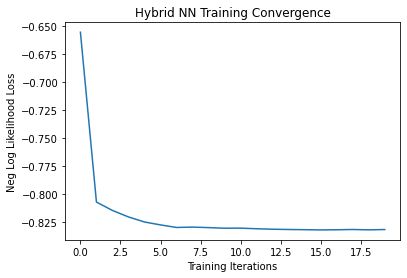

In [273]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

model.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_samples_show:
#             break
#         output = model(data)
        
#         pred = output.argmax(dim=1, keepdim=True) 

#         axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

#         axes[count].set_xticks([])
#         axes[count].set_yticks([])
#         axes[count].set_title('Predicted {}'.format(pred.item()))
        
#         count += 1